# Modules


In [ ]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data set

## get data

In [ ]:
import gdown
gdown.download("https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk&confirm=t", quiet=False)
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip 

Downloading...
From: https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk&confirm=t
To: /content/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:24<00:00, 35.1MB/s]


## create dataset object

In [ ]:
# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in ./train is 25000
Number of images in ./test1 is 12500


In [ ]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

./train/dog.11182.jpg


In [ ]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

In [ ]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0 

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [ ]:
# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

In [ ]:
# Getting a data entry
train.__getitem__(0)

(tensor([[[0.2471, 0.2549, 0.3255,  ..., 0.6157, 0.6078, 0.5216],
          [0.2431, 0.2431, 0.2941,  ..., 0.6235, 0.6039, 0.4980],
          [0.2157, 0.2157, 0.2706,  ..., 0.6471, 0.5725, 0.5020],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.9608, 0.9490, 0.9412],
          [0.0235, 0.0196, 0.0118,  ..., 0.9490, 0.9412, 0.9333],
          [0.0196, 0.0235, 0.0314,  ..., 0.9373, 0.9373, 0.9294]],
 
         [[0.1765, 0.1843, 0.2392,  ..., 0.4667, 0.4392, 0.3373],
          [0.1647, 0.1686, 0.2235,  ..., 0.4627, 0.4314, 0.3137],
          [0.1569, 0.1569, 0.2078,  ..., 0.4784, 0.4000, 0.3255],
          ...,
          [0.0471, 0.0353, 0.0314,  ..., 0.9333, 0.9216, 0.9137],
          [0.0471, 0.0431, 0.0353,  ..., 0.9216, 0.9137, 0.9059],
          [0.0392, 0.0392, 0.0549,  ..., 0.9098, 0.9098, 0.9020]],
 
         [[0.1216, 0.1216, 0.1333,  ..., 0.4275, 0.4039, 0.3137],
          [0.1020, 0.0980, 0.1020,  ..., 0.4392, 0.4118, 0.2941],
          [0.0784, 0.0745, 0.0745,  ...,

In [ ]:
# Getting the shape of a single image
print(val.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


## train validation split

In [ ]:
train, val = torch.utils.data.random_split(train,[20000,5000]) 

In [ ]:
# Getting a size of our
print(len(train))
print(len(val))

20000
5000


In [ ]:
# Let's create an array of our labels
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val)) ]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


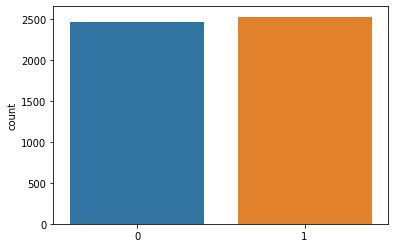

In [ ]:
import seaborn as sns

sns.countplot(val_set_class_count)

## Dataloaders

In [ ]:
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

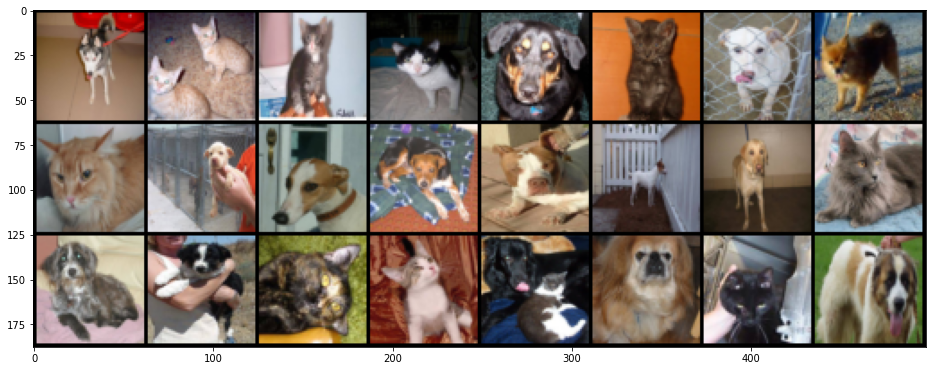

In [ ]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

# build model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            ) 
            
        self.conv2 =   nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 
        self.conv3 =   nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 

        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU()
        )
            
        self.fc2 = nn.Sequential(
        nn.Linear(128,2),
        )
                
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1) 

In [ ]:
model = CNN()
model.cuda()
summary(model,(3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

In [ ]:
type(train_dataset)

torch.utils.data.dataloader.DataLoader

In [ ]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Set our unit for tqdm and number of iterations i.e. len(train_dataset) no need for len as train_dataset is an iteratable
    # tepoch becomes 
    with tqdm(train_dataset, unit="batch") as tepoch:
        # our progress bar labels
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for data,label in tepoch:
            data,label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimiser.step() 

            train_running_loss += loss.item() * data.size(0)

            _, pred = torch.max(output.data, 1)

            # Keep track of how many images have been foward propagated
            total += label.size(0)
            # Keep track of how many were predicted to be correct
            correct += (pred == label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Get our validation accuracy and loss scores
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # We don't need gradients for validation, so wrap in  no_grad to save memory
        with torch.no_grad():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                # Calacuate the running loss by multiplying loss value by batch size
                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)    
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()

            val_accuracy.append(correct/total)
            # Calcuate loss per epoch by dividing runing loss by number of items in validation set
            val_loss.append(val_running_loss/len(val_dataset))

            #print(val_running_loss)
            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

<ipython-input-20-ed1d14d94d43>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.5983
Epoch 1 Training Loss = 21.085661613464357
Epoch 1 Validation Accuracy = 0.6904
Epoch 1 Validation Loss = 19.325347368884238


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.70295
Epoch 2 Training Loss = 18.84838671875
Epoch 2 Validation Accuracy = 0.7196
Epoch 2 Validation Loss = 18.29314426252037


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.7418
Epoch 3 Training Loss = 17.752600398254394
Epoch 3 Validation Accuracy = 0.7534
Epoch 3 Validation Loss = 17.378119991083814


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.77275
Epoch 4 Training Loss = 16.92111944885254
Epoch 4 Validation Accuracy = 0.7776
Epoch 4 Validation Loss = 16.608493224830383


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.786
Epoch 5 Training Loss = 16.4689487701416
Epoch 5 Validation Accuracy = 0.6956
Epoch 5 Validation Loss = 19.00825355918544


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.79595
Epoch 6 Training Loss = 16.222989472961427
Epoch 6 Validation Accuracy = 0.7564
Epoch 6 Validation Loss = 17.2366059054235


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.80845
Epoch 7 Training Loss = 15.851909927368164
Epoch 7 Validation Accuracy = 0.7932
Epoch 7 Validation Loss = 16.232572783330443


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.81965
Epoch 8 Training Loss = 15.543942665100097
Epoch 8 Validation Accuracy = 0.788
Epoch 8 Validation Loss = 16.28352764457654


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.82895
Epoch 9 Training Loss = 15.262591120910644
Epoch 9 Validation Accuracy = 0.8008
Epoch 9 Validation Loss = 16.05069200248475


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.83635
Epoch 10 Training Loss = 15.034663858032227
Epoch 10 Validation Accuracy = 0.798
Epoch 10 Validation Loss = 16.085059955621222


In [ ]:
train_loss

[21.085661613464357,
 18.84838671875,
 17.752600398254394,
 16.92111944885254,
 16.4689487701416,
 16.222989472961427,
 15.851909927368164,
 15.543942665100097,
 15.262591120910644,
 15.034663858032227]

NameError: ignored

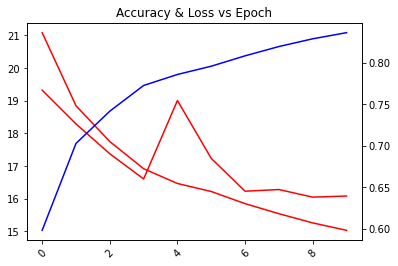

In [ ]:
epoch_log = [*range(epochs)]

# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuarcy, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [ ]:
PATH = './cats_vs_dogs_10_epochs.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# Create an instance of the model and move it (memory and operations) to the CUDA device.
model = CNN()
model.to(device)

# Load weights from the specified path
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

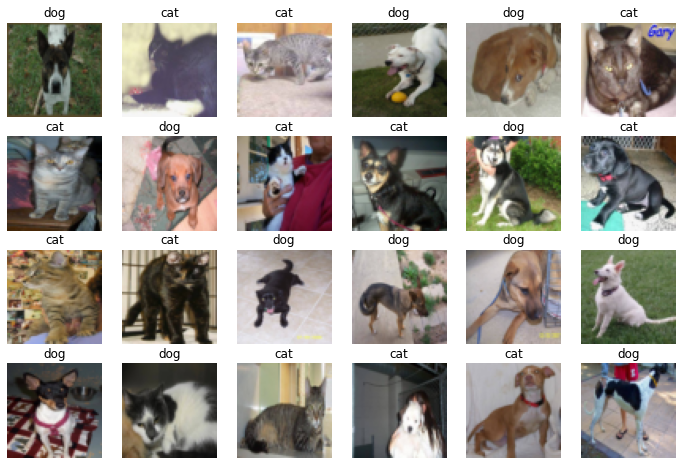

In [ ]:
samples, _ = next(iter(val_dataset))
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))